# **Classifying heart disease patients from Cleveland.**
### Introduction:
The term heart (cardiovascular) disease describes a range of heart conditions that arise from problems with the heart and blood vessels. One of these is coronary artery disease, which is when the arteries supplying blood to the heart narrow. Many risk factors can increase the chance of developing this disease, including cholesterol levels and maximum heart rate.

High levels of cholesterol result in fatty deposits in blood vessels that clog them, making it difficult for enough blood to flow through the arteries. When these deposits break suddenly, they form a clot resulting in a heart attack or stroke. If a patient has clogged arteries, the maximum heart rate should increase to continue to pump enough blood.

The goal of this project will be to use these risk factors to classify patients based on likeliness to have heart disease.

The question we will be addressing is: **Is a new patient likely to have heart disease, based on cholesterol levels and maximum heart rate achieved?**

### Preliminary exploratory data analysis:
* ~~Demonstrate that the dataset can be read from the web into R ~~
* ~~Clean and wrangle your data into a tidy format~~
* Using **only training data**, summarize the data in at least one table (this is exploratory data analysis). An example of a useful table could be one that reports the number of observations in each class, the means of the predictor variables you plan to use in your analysis and how many rows have missing data. 
* Using **only training data**, visualize the data with at least one plot relevant to the analysis you plan to do (this is exploratory data analysis). An example of a useful visualization could be one that compares the distributions of each of the predictor variables you plan to use in your analysis.

In [2]:
# importing libraries
library(tidyverse)
library(tidymodels)
library(repr)
library(RColorBrewer)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [3]:
set.seed(1)
# reading the dataframe from URL, assigning col names and types
cleveland_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", 
                           col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", 
                                         "thalach", "exang", "oldpeak", "slope", "ca", "thal", "prob"),
                           col_types = list("d", "d", "d", "d", "d", "d", "d", "d", "d", "d", "d", "f", "f", "d"))

# cleaning, wrangling data
cleveland_clean <- cleveland_data %>%
                    filter_all(all_vars(. != "?"), all_vars(. == -9.0)) %>%
                    mutate(diag = (prob > 0)) %>%
                    mutate(sex = as.factor(as.integer(sex)), cp = as.factor(as.integer(cp)), 
                           fbs = as.factor(as.integer(fbs)), restecg = as.factor(as.integer(restecg)),
                           exang = as.factor(as.integer(exang)), thal = as.factor(as.integer(thal)),
                           ca = as.factor(as.integer(ca)), slope = as.factor(as.integer(slope)))

#splitting dataframe into training, testing datasets
cleveland_split <- initial_split(cleveland_clean, prop = 3/4, strata = prob)

cleveland_training <- training(cleveland_split)
cleveland_testing <- testing(cleveland_split)

head(cleveland_training)

cleveland_summary <- cleveland_training %>%
                     group_by(diag) %>%
                     summarize(n = n())

cleveland_summary

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,prob,diag
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<lgl>
63,1,1,145,233,1,2,150,0,2.3,3,1,1,0,FALSE
67,1,4,160,286,0,2,108,1,1.5,2,2,2,2,TRUE
67,1,4,120,229,0,2,129,1,2.6,2,3,3,1,TRUE
37,1,3,130,250,0,0,187,0,3.5,3,1,2,0,FALSE
41,0,2,130,204,0,2,172,0,1.4,1,1,2,0,FALSE
56,1,2,120,236,0,0,178,0,0.8,1,1,2,0,FALSE


`summarise()` ungrouping output (override with `.groups` argument)



diag,n
<lgl>,<int>
FALSE,120
TRUE,103


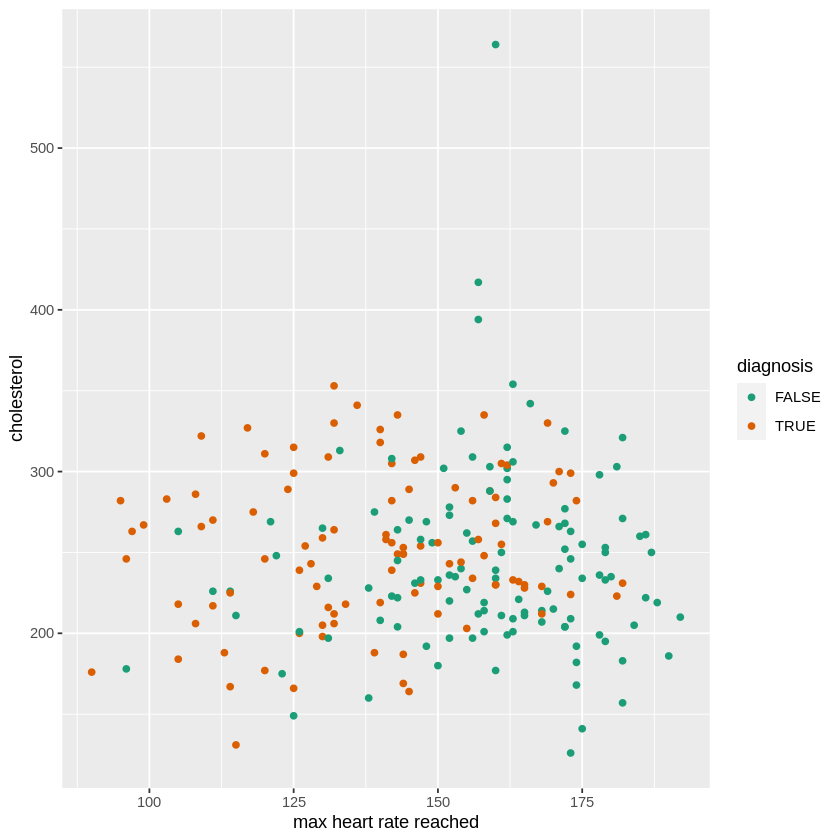

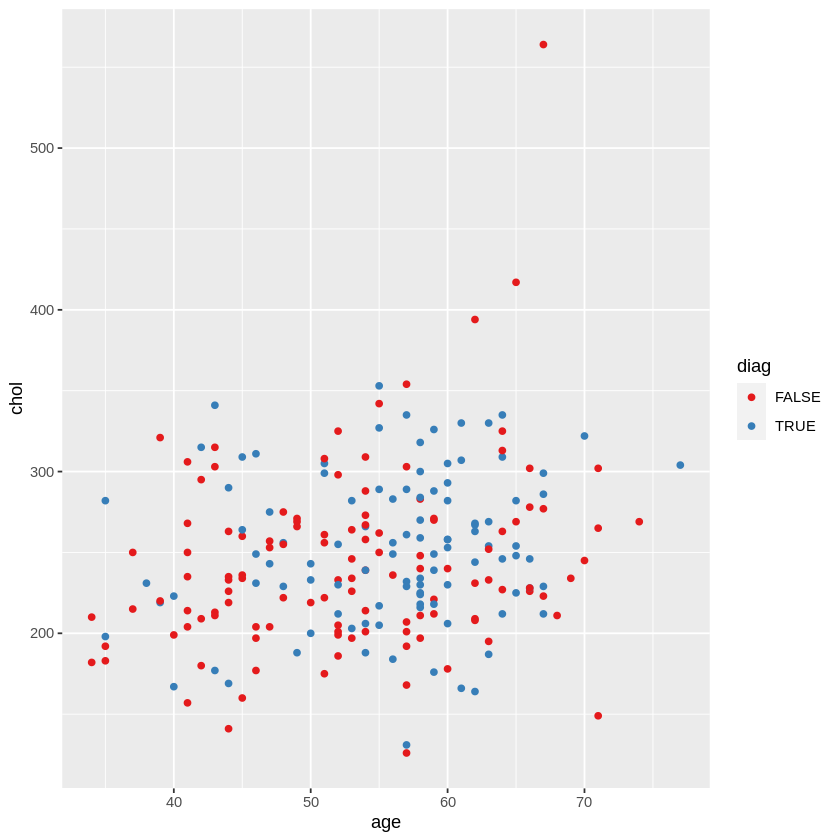

In [12]:
#plotting the training data


plot1 <- ggplot(cleveland_training, aes(x = thalach, y = chol, color = diag)) +
                 geom_point() +
                 labs(x = "max heart rate reached", y = "cholesterol", color = "diagnosis") +
                 scale_color_brewer(palette = "Dark2")

plot2 <- ggplot(cleveland_training, aes(x = age, y = chol, color = diag)) +
                 geom_point() +
                 labs() + 
                 scale_color_brewer(palette = "Set1")

plot1
plot2

#!!! test with other <fct> cols

### Methods:
We are using the processed.cleveland.data from the Heart Disease Database (originally collected from the Cleveland Clinic Foundation) to predict if a patient from Cleveland will have heart disease. The columns in the dataset are “age”, “sex”, “cp”, “trestbps”, “chol”, “fbs”, “restecg”, “thalach”, “exang”, “oldpeak”, “slope”, “ca”, “thal”, and “num”.  Each column is numeric-valued and there are 303 rows.

The “num” column uses integers to distinguish presence (1,2,3,4) from absence (0), so a new column "diag" has been appended to narrow diagnoses down to TRUE or FALSE.

To visualize the data, we generated scatter plots of different 

### Expected outcomes and significance:
 * What do you expect to find?
 * What impact could such findings have?
 * What future questions could this lead to?